In [42]:
%load_ext autoreload
%autoreload 2

# Ensure your Python version makes sense.
import sys
sys.version

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pandas as pd
import json, os
from glob import glob
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    
    Parameters
    ----------
    path : str
        path to tensorflow log file
    
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

# Daniel note: tsplot() might be deprecated
def plot_data(data, value="Eval_AverageReturn", other_value=None):
    sns.set(style="darkgrid", font_scale=1.5)
    if not isinstance(data, list):
        data = [data]
    for df in data: 
        ax = sns.lineplot(data=df, x="Iteration", y=value, hue="Condition", style="Condition", markers=False, dashes=False)
        if other_value:
            m = df[value].to_numpy().squeeze()
            std = df[other_value].to_numpy().squeeze()
            ax.fill_between(df['Iteration'], y1=m-std, y2=m+std, alpha=.5)
        
#         data = pd.concat(data, ignore_index=False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


def get_datasets(fpath, condition=None, values=["Eval_AverageReturn"]):
    if not isinstance(values, list):
        values = [values]
    unit = 0
    datasets = []
    # get tensorboard event file from directory 
    event = glob(os.path.join(fpath, 'events.out.tfevents*'))[0]
    
    experiment_data = tflog2pandas(event)
    selected_data = [experiment_data.loc[experiment_data['metric'] == value]['value'] for value in values]
    invert_df = pd.DataFrame(zip(experiment_data['step'].astype(np.int), *selected_data), columns=['Iteration'] + values)    
    invert_df.insert(
        len(invert_df.columns),
        'Unit',
        unit
    )        
    invert_df.insert(
        len(invert_df.columns),
        'Condition',
        condition or fpath
    )
    datasets.append(invert_df)
    return datasets


def plot(logdir, head, legend, plot_values='Eval_AverageReturn', other_value=None):
    use_legend = False
    if legend is not None:
        assert len(legend) == len(logdir), "Must give a legend title for each set of experiments."
        use_legend = True

    data = []
    if not isinstance(plot_values, list): 
        plot_values = [plot_values]
    if not other_value:
        other_value = []
    else:
        other_value = [other_value]
    if use_legend:
        for logdir, legend_title in zip(logdir, legend):
            data += get_datasets(os.path.join(head,logdir), legend_title, plot_values + other_value)
    else:
        for logdir in logdir:
            data += get_datasets(os.path.join(head,logdir), values=plot_values + other_value)

    for value in plot_values:
        plot_data(data, value=value, other_value=other_value)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Results with the small batch:


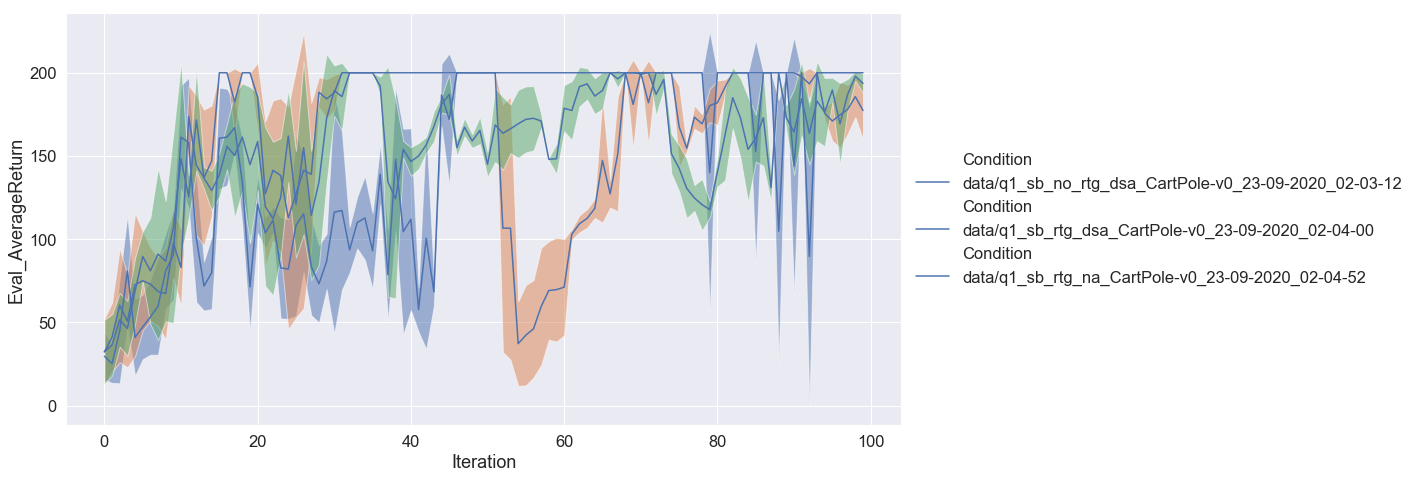


Results with the large batch:


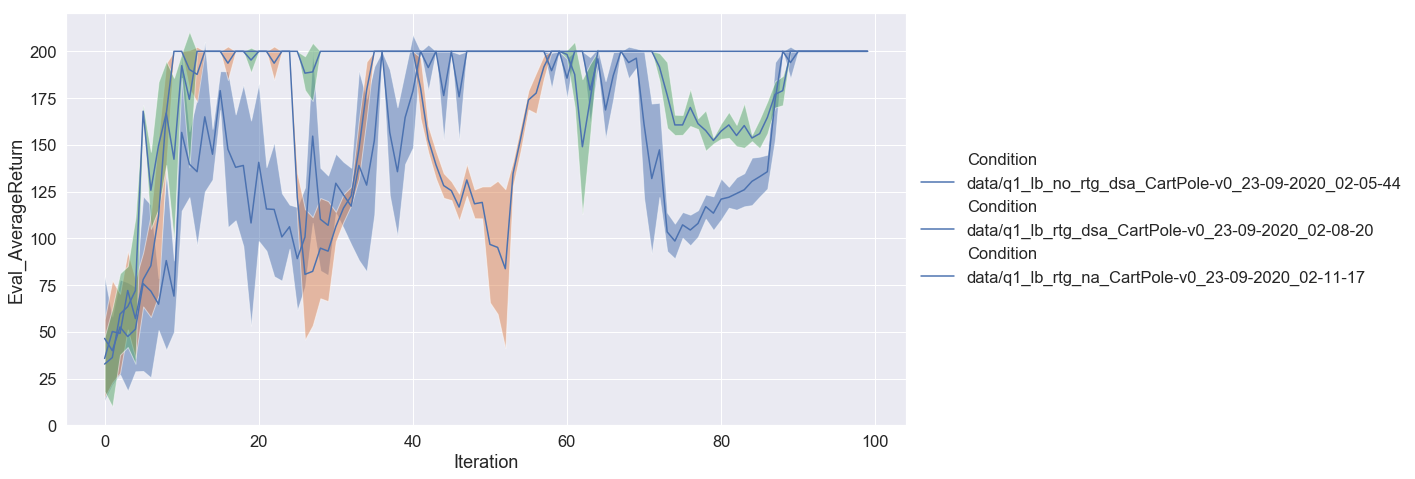

In [43]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.
from matplotlib import rcParams

rcParams['figure.figsize'] = 20, 7

lb_experiments = [
    'q1_lb_no_rtg_dsa_CartPole-v0_23-09-2020_02-05-44',
    'q1_lb_rtg_dsa_CartPole-v0_23-09-2020_02-08-20',
    'q1_lb_rtg_na_CartPole-v0_23-09-2020_02-11-17'
]

sb_experiments = [
    'q1_sb_no_rtg_dsa_CartPole-v0_23-09-2020_02-03-12',
    'q1_sb_rtg_dsa_CartPole-v0_23-09-2020_02-04-00',
    'q1_sb_rtg_na_CartPole-v0_23-09-2020_02-04-52'
]
    

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
print("Results with the small batch:")
plot(sb_experiments, head='data', legend=None, plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')
print("\nResults with the large batch:")
plot(lb_experiments, head='data', legend=None, plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')

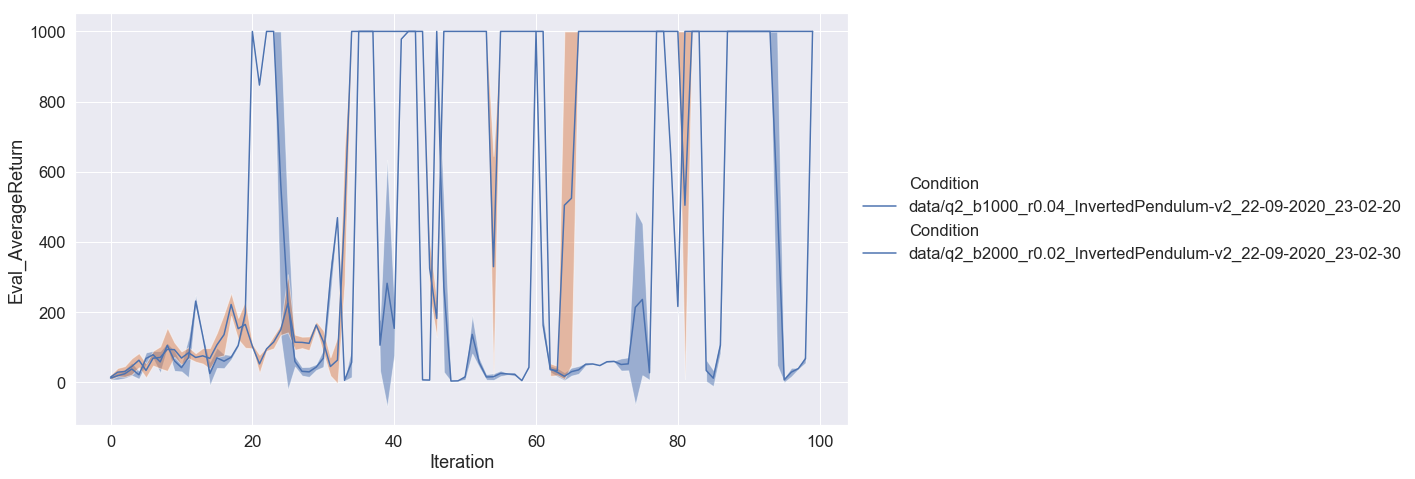

In [44]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.
q2_experiment = [
    'q2_b1000_r0.04_InvertedPendulum-v2_22-09-2020_23-02-20', 
    'q2_b2000_r0.02_InvertedPendulum-v2_22-09-2020_23-02-30'
]
plot(q2_experiment, head='data', legend=None, plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')

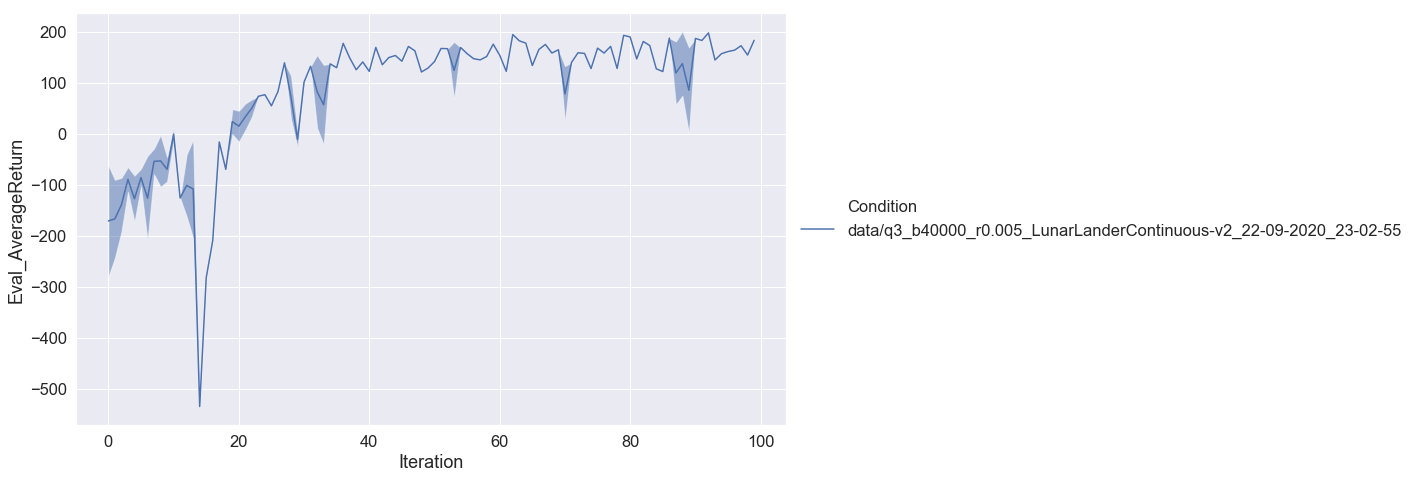

In [45]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.
q3_experiment = ['q3_b40000_r0.005_LunarLanderContinuous-v2_22-09-2020_23-02-55']
plot(q3_experiment, head='data', legend=None, plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')

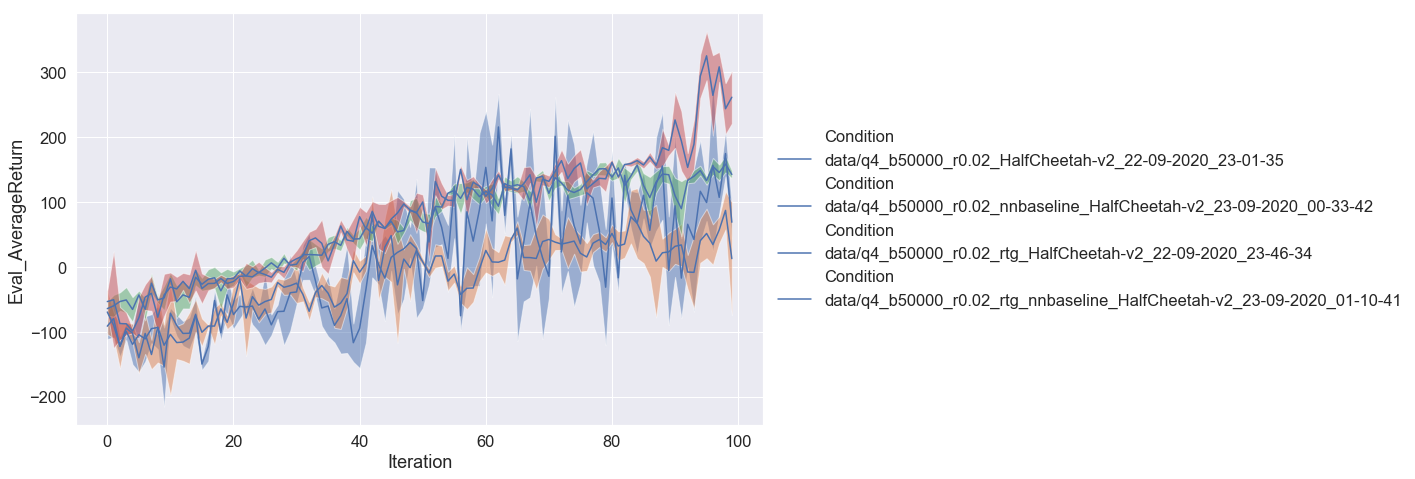

In [46]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.
q4_experiments = [
    'q4_b50000_r0.02_HalfCheetah-v2_22-09-2020_23-01-35',
    'q4_b50000_r0.02_nnbaseline_HalfCheetah-v2_23-09-2020_00-33-42',
    'q4_b50000_r0.02_rtg_HalfCheetah-v2_22-09-2020_23-46-34',
    'q4_b50000_r0.02_rtg_nnbaseline_HalfCheetah-v2_23-09-2020_01-10-41'
]
plot(q4_experiments, head='data', legend=None, plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')

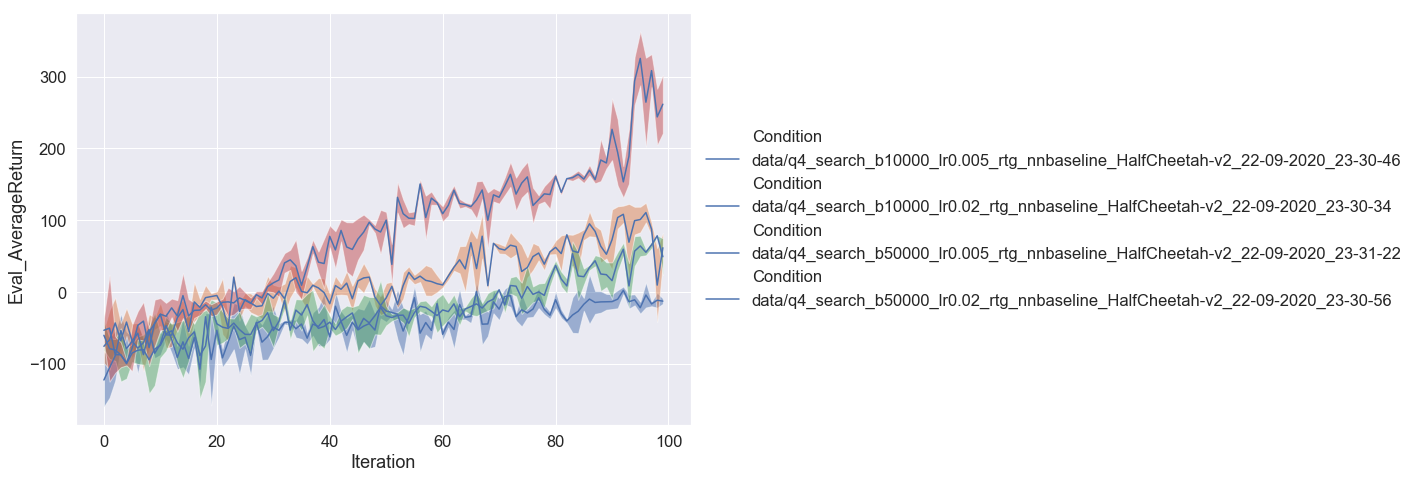

In [47]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.
q4_experiments = [
    'q4_search_b10000_lr0.005_rtg_nnbaseline_HalfCheetah-v2_22-09-2020_23-30-46',
    'q4_search_b10000_lr0.02_rtg_nnbaseline_HalfCheetah-v2_22-09-2020_23-30-34',
    'q4_search_b50000_lr0.005_rtg_nnbaseline_HalfCheetah-v2_22-09-2020_23-31-22',
    'q4_search_b50000_lr0.02_rtg_nnbaseline_HalfCheetah-v2_22-09-2020_23-30-56'
]
plot(q4_experiments, head='data', legend=None, plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')